# Object Segmentation and object localisation using image classifier
This tutorial is to show that, we can use an image classifier for much complex task like image segmentation.

---


***Note*** This should note be used for segmentation/object detection  as there are much better method for these tasks. But this can be used as a visualisation method. 

## Importing all the library which we will be needing.

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision 
import torchvision.models as models

from PIL import Image
import cv2
import json

%matplotlib inline

## Define useful functions for later use

**Function to upload file to colab**

In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

#### Function to prepare image for classification

In [0]:
def prepare_image(img):
  img=img.resize((299,299), Image.ANTIALIAS)
  img_tensor_converter=transforms.ToTensor()
  img_tensor=img_tensor_converter(img)

## generate image 

### Loading the pretrained model
Here we are using Inception V3 but feel free to use any classification model.

In [0]:
inception = models.inception_v3(pretrained=True,aux_logits=True, transform_input=False)
inception=inception.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:02<00:00, 51.4MB/s]


### Prepare image

#### Upload image

In [0]:
image_name=upload_files()[0]

Saving IMG-20181129-WA0007.jpg to IMG-20181129-WA0007.jpg


In [0]:
img=Image.open(image_name)
img=img.resize((299,299), Image.ANTIALIAS)
plt.imshow(np.asarray(img))

#### Transform image for classification

**Normalising and adding another dimension for matching models input shape**

In [0]:
img_transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),])
data=img_transform(img).unsqueeze(0)

**Checking shape of the input**

In [0]:
data.size()

torch.Size([1, 3, 299, 299])

**Enabling Gradient calculation for data**

In [0]:
data=Variable(data,requires_grad=True)

### Predict and calculate loss

#### Predict 

In [0]:
pred=inception(data)
_, target = torch.max(pred, 1)

Loading the imagenet label json to show the actual class name.(optinal)

In [0]:
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

percentage = (torch.nn.functional.softmax(pred, dim=1)[0] * 100).detach().numpy()
for idx in percentage.argsort()[-3:][::-1]:
    print(idx,idx2label[idx],percentage[idx],idx)

527 desktop_computer 16.184938 527
553 file 15.711024 553
713 photocopier 4.04817 713


#### Calculating loss

In [0]:
loss = F.nll_loss(pred,target )
print(loss.item())

-6.69184684753418


In [0]:
loss.backward()
# Collect datagrad
data_grad = data.grad

### Generating segmentation

#### Generating mask

In [0]:
smap=data.reshape((3,299,299)).detach().numpy() 

**Removing sign**

In [0]:
smap=np.abs(smap)

**Taking maximum along all channels**

In [0]:
mask=np.amax(smap,axis=0)

**Threshold image using median value**
There can be lot of more starategies hare like a fixed threshold value

In [0]:
threshold=np.median(mask)

In [0]:
mask=mask>threshold

In [0]:
mask=np.array(mask*255,dtype=np.uint8)

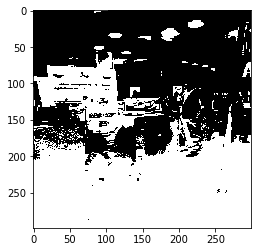

In [0]:
plt.imshow(mask, cmap='gray',vmin=0, vmax=255)

#### Generating bounding box

In [0]:
contours= cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]

In [0]:
img=np.asarray(img)

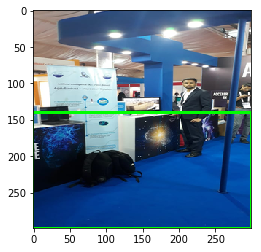

In [0]:
cnt=max(contours,key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cnt)

# draw a green rectangle to visualize the bounding rect
cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

In [0]:
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (x,y,x+w,y+h)
image=cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

In [0]:
image[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 3, ..., 3, 3, 2],
       [2, 2, 3, ..., 3, 3, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

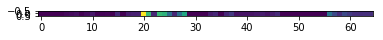

In [0]:
plt.imshow(image[-1])
plt.show()

### pre

In [0]:
from torch.autograd import Variable

data=img_tensor.unsqueeze(0).cpu()
data=Variable(torch.Tensor(data),requires_grad=True)

target=torch.LongTensor([388])
pred=inception(data)


388 giant_panda 88.413895 388
805 soccer_ball 0.24885894 805
850 teddy 0.21238646 850


In [0]:
loss = F.nll_loss(pred,target )

print(loss.item())

-9.154265403747559


In [0]:
loss.backward()

# Collect datagrad
data_grad = data.grad.data

In [0]:
data=data_grad.numpy()

In [0]:
smap=data.reshape((3,299,299))

In [0]:
resimg=np.amax(smap,axis=0)

NameError: ignored

In [0]:
resimg*=0.45/128

NameError: ignored

In [0]:
resimg

NameError: ignored

In [0]:
torchvision.utils.save_image(data_grad,"res.jpg")

In [0]:
import cv2
img=cv2.imread("res.jpg")

In [0]:
th=np.max(img,axis=2)

In [0]:
cv2.imwrite("th.jpg",th)

True

In [0]:
ret3,th3 = cv2.threshold(th,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


In [0]:
th2=cv2.adaptiveThreshold(th,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,11,2)

In [0]:
cv2.imwrite("th3.jpg",th2)

True

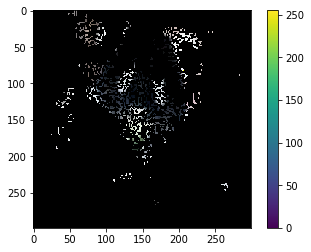

(<matplotlib.image.AxesImage at 0x7f45288139e8>,
 None)

In [0]:
img = cv2.imread('index.jpeg')
img=cv2.resize(img,(299,299))
img=img*th2.reshape(299,299,1)
plt.imshow(img),plt.colorbar(),plt.show()

In [0]:
kernel = np.ones((11,11),np.uint8)
closing = cv2.morphologyEx(th2, cv2.MORPH_CLOSE, kernel)

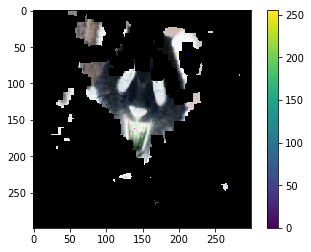

(<matplotlib.image.AxesImage at 0x7f45287bdc50>,
 None)

In [0]:
img = cv2.imread('index.jpeg')
img=cv2.resize(img,(299,299))
img=img*closing.reshape(299,299,1)
plt.imshow(img),plt.colorbar(),plt.show()

In [0]:
ret,contours, hier = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

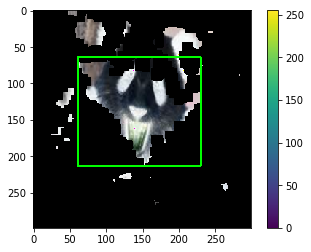

(<matplotlib.image.AxesImage at 0x7f45286e2198>,
 None)

In [0]:
cnt=max(contours,key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cnt)
    # draw a green rectangle to visualize the bounding rect
cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(img),plt.colorbar(),plt.show()

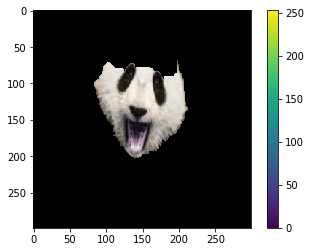

(<matplotlib.image.AxesImage at 0x7f4528680278>,
 None)

In [0]:
img = cv2.imread('index.jpeg')
img=cv2.resize(img,(299,299))
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (x,y,x+w,y+h)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
cv2.imwrite('img.jpg',img)
plt.imshow(img),plt.colorbar(),plt.show()

In [0]:
data.detach().numpy()[np.abs(data_grad.numpy())<1]=0

AttributeError: ignored

In [0]:
black=np.zeros((299,299,3),dtype=np.uint8)

black[np.abs(data_grad.view(299,299,3).numpy())<1]=255


In [0]:
import cv2
cv2.imwrite("thresh.jpg",black)

True

In [0]:
data.shape

(1, 3, 299, 299)

In [0]:
data_grad.shape

In [0]:
from google.colab import files
files.download( "thresh.jpg" )